#Homework 1
Group: Zach Aldrich, Alec Grubs, James Krach, Brian Lakey, Greg Merchant, and Francisco Sananez

## Part A (basic text mining)

### A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

In [1]:
import pandas as pd
%pylab inline
import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

Populating the interactive namespace from numpy and matplotlib


In [2]:
salaryData = pd.read_csv('data/Train_rev1.csv')[['FullDescription', 'SalaryNormalized']][:20000]
salaryData['Raw'] = salaryData['FullDescription'].str.decode('utf8')

In [3]:
salary_tokens = salaryData['Raw'].map(WhitespaceTokenizer().tokenize)
salary_pos = salary_tokens.map(nltk.pos_tag)

In [4]:
salary_pos_list = []

for l in salary_pos:
    for number in l:
        salary_pos_list.append(number)

pos_count = Counter((tag for (word,tag) in salary_pos_list))

mc_pos = pos_count.most_common(5)

mc_pos_freq = [(word,round((float(tag)/sum(pos_count.values()).astype(float))*100,2)) for (word,tag) in mc_pos]

#### The top 5 parts of speech from this corpus of job descriptions are:

In [5]:
mc_pos

[('NNP', 918775),
 ('NN', 839969),
 ('IN', 472430),
 ('DT', 340607),
 ('JJ', 334252)]

#### These parts of speech appear with the following frequencies:

In [6]:
mc_pos_freq

[('NNP', 20.07), ('NN', 18.35), ('IN', 10.32), ('DT', 7.44), ('JJ', 7.3)]

### A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law.

In [7]:
salary_token_list = []

for i in salary_tokens:
    for number in i:
        salary_token_list.append(number)

sal_replacer = ['****']        
        
salary_lower = [w.lower() for w in salary_token_list if w not in sal_replacer]
        
word_count = Counter((word for word in salary_lower))

most_common_words = word_count.most_common(100)

rank_freq = [x[1] for x in most_common_words]
rank = xrange(1,101)
log_rank = [log(x) for x in xrange(1,101)]
    
inverse_rank = [1/float(i) for i in rank]

#### As seen in the plot below, if we plot the frequency of top 100 most common words versus their rank on a loglog plot, we see a curve that is similar to Zipf's law for the majority of the common words. We see the curve tail off as the rank of the word decreases as many of these words have similar frequencies in our corpus at this low ranking. This differs from Zipf's law which assumes the frequencies will continue to decrease as the rank decreases.

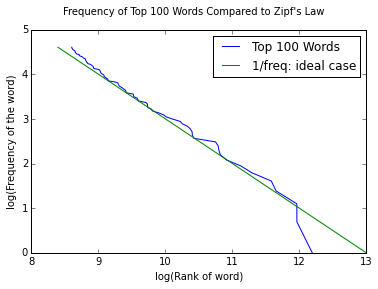

In [12]:
plt.plot(log(rank_freq),log_rank)
plt.plot(log(inverse_rank)+ 13,log_rank)
plt.suptitle('Frequency of Top 100 Words Compared to Zipf\'s Law')
plt.xlabel('log(Rank of word)')
plt.ylabel("log(Frequency of the word)")
plt.legend(("Top 100 Words","1/freq: ideal case"),"upper right")

### A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [13]:
wordnet_lemmatizer =  WordNetLemmatizer()

no_stops = [w for w in salary_lower if w not in stopwords.words("english")]

lemma = [wordnet_lemmatizer.lemmatize(i) for i in no_stops]

lemma_word_count = Counter((word for word in lemma))

mc_lemma_words = lemma_word_count.most_common(10)

mc_lemma_words_freq = [(word,round((float(tag)/sum(lemma_word_count.values()).astype(float))*100,2)) for (word,tag) in mc_lemma_words]

#### The top 10 most common words from the corpus are:

In [14]:
mc_lemma_words

[(u'experience', 28530),
 (u'work', 21981),
 (u'working', 18111),
 (u'role', 18040),
 (u'client', 17141),
 (u'within', 16858),
 (u'team', 16438),
 (u'service', 14952),
 (u'business', 14852),
 (u'please', 14554)]

#### These words appear with the following frequencies:

In [15]:
mc_lemma_words_freq

[(u'experience', 1.0),
 (u'work', 0.77),
 (u'working', 0.63),
 (u'role', 0.63),
 (u'client', 0.6),
 (u'within', 0.59),
 (u'team', 0.57),
 (u'service', 0.52),
 (u'business', 0.52),
 (u'please', 0.51)]

# Part B (predict salary from job description)

### B1. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [16]:
top_quartile = salaryData['SalaryNormalized'].describe()['75%']
salaryData['high'] = (salaryData['SalaryNormalized'] > top_quartile).astype(int)
salaryData.drop('SalaryNormalized', axis=1, inplace=True)

In [93]:
# data splits
#change X_train_ and y_train_ back if even split isn't needed
from sklearn.cross_validation import train_test_split

X_train_, X_test, y_train_, y_test = train_test_split(salaryData['FullDescription'],
                                                    salaryData['high'],
                                                    test_size=0.4, random_state=1)

In [94]:
import random as rnd
y_train_high = [x for x in y_train_ if x == 1]
y_train_high_pos = [x for x in xrange(0,len(y_train_)) if y_train_[x] == 1]
X_train_high = [X_train_[x] for x in y_train_pos]
all_pos = list(xrange(0,len(y_train_)))
low_pos = list(set(all_pos) - set(y_train_high_pos))
low_train_pos = rnd.sample(low_pos, len(y_train_high))
all_train_pos = sorted(y_train_high_pos + low_train_pos)
X_train = [X_train_[x] for x in all_train_pos]
y_train = [y_train_[x] for x in all_train_pos]

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
trainVectorizer = CountVectorizer(min_df=1)

In [97]:
trainVectorCount = trainVectorizer.fit_transform(X_train)
testVectorCount = trainVectorizer.transform(X_test)

In [98]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
model = classifier.fit(trainVectorCount, y_train)

In [99]:
from sklearn.metrics import confusion_matrix
y_hat_train = model.predict(trainVectorCount)

cm = confusion_matrix(y_train,y_hat_train)
y_hat_test = model.predict(testVectorCount)
cm2 = confusion_matrix(y_test,y_hat_test)
print cm2

[[4744 1310]
 [ 405 1541]]


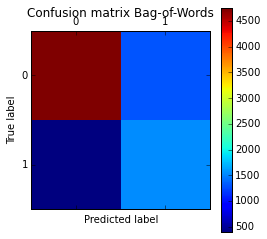

In [100]:
plt.matshow(cm2)
plt.title('Confusion matrix Bag-of-Words')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### B2 Lemmatization

We would expect that the lemmatization model would perform better since it is not tokenizing based only on punctuation but on the root of the word. This would in theory mean that a classification model would be able to classify documents based on the root words instead of particular conjugations and thus perform better since there are fewer features (i.e. multiple conjugations/features collapse into one root).

In [101]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

LemmaVector = CountVectorizer(tokenizer=LemmaTokenizer())

In [102]:
trainVectorLemma = LemmaVector.fit_transform(X_train)
testVectorLemma = LemmaVector.transform(X_test)

In [103]:
classifierLemma = MultinomialNB()
modelLemma = classifierLemma.fit(trainVectorLemma, y_train)

In [104]:
y_hat_trainLemma = modelLemma.predict(trainVectorLemma)

y_hat_testLemma = modelLemma.predict(testVectorLemma)
cm3 = confusion_matrix(y_test,y_hat_testLemma)
print cm3

[[4732 1322]
 [ 408 1538]]


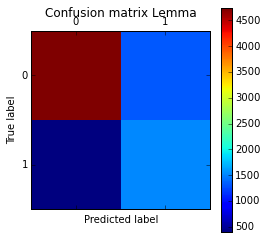

In [105]:
plt.clf()
plt.matshow(cm3)
plt.title('Confusion matrix Lemma')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Somewhat counterintuitively, the lemmatization model did not perform noticably better or worse from the simpler stemming model despite being much more computationally expensive.

### B3 Stopwords

In [106]:
stopwordVector = CountVectorizer(stop_words='english',
                                tokenizer=LemmaTokenizer())

In [107]:
trainStopwordsVector = stopwordVector.fit_transform(X_train)
testStopwordsVector = stopwordVector.transform(X_test)

In [108]:
classifierStopwords = MultinomialNB()
modelStopwords = classifierStopwords.fit(trainStopwordsVector, y_train)

In [109]:
y_hat_trainStopwords = modelStopwords.predict(testStopwordsVector)
cm4 = confusion_matrix(y_test, y_hat_trainStopwords)
print cm4

[[4744 1310]
 [ 400 1546]]


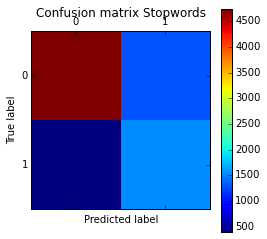

In [110]:
plt.clf()
plt.matshow(cm4)
plt.title('Confusion matrix Stopwords')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [111]:
modelCoefficients = modelStopwords.coef_[0]
modelFeatures = stopwordVector.get_feature_names()

In [112]:
feature_Coeffs = []
if len(modelCoefficients)==len(modelFeatures):
    for i in range(len(modelCoefficients)):
        feature_Coeffs.append((modelFeatures[i], modelCoefficients[i]))

In [113]:
from operator import itemgetter
feature_Coeffs = sorted(feature_Coeffs,key=itemgetter(1))

#### Top 10 High Salary Features:

In [114]:
feature_Coeffs[-10:]

[(u'client', -5.0302863672039457),
 (u'work', -5.022948380751032),
 (u'role', -4.9794978373953676),
 (u'business', -4.8812927545961209),
 (u'team', -4.8745003640359563),
 (u':', -4.6235491099010435),
 (u'****', -4.555622310765683),
 (u'experience', -4.4964861040622282),
 (u'.', -3.0819242349013454),
 (u',', -2.9417482995581548)]

#### Top 10 Low Salary Features

In [115]:
feature_Coeffs[:10]

[(u"'appointment", -13.237142795603596),
 (u"'boh", -13.237142795603596),
 (u"'booked", -13.237142795603596),
 (u"'brand", -13.237142795603596),
 (u"'building", -13.237142795603596),
 (u"'builtin", -13.237142795603596),
 (u"'busy", -13.237142795603596),
 (u"'buzz", -13.237142795603596),
 (u"'canvassing", -13.237142795603596),
 (u"'care", -13.237142795603596)]

### B4 Part-of-Speech Bi-grams

In [116]:
def pos_BiGramizer(doc):
    tokens = nltk.word_tokenize(doc.lower())
    tagged = nltk.pos_tag(tokens)
    ord_pos = [y for x, y in tagged]
    pos_BiGrams = []
    for i in range(len(ord_pos)-1):
        pos_BiGrams.append(ord_pos[i] + '_' + ord_pos[i+1])
    return list(pos_BiGrams)

In [117]:
def pos_BG_count_tokenizer(doc):
    return nltk.word_tokenize(doc) + pos_BiGramizer(doc)

In [118]:
class POS_BG_Tokenizer(object):
    def __call__(self, doc):
        return pos_BG_count_tokenizer(doc)

In [119]:
posBGVector = CountVectorizer(stop_words='english',
                                tokenizer=POS_BG_Tokenizer())

In [120]:
trainBGVector = posBGVector.fit_transform(X_train)
testBGVector = posBGVector.transform(X_test)

In [121]:
classifierBG = MultinomialNB()
modelBG = classifierBG.fit(trainBGVector, y_train)

In [122]:
y_hat_trainBG = modelBG.predict(testBGVector)
cm5 = confusion_matrix(y_test, y_hat_trainBG)
print cm5

[[4745 1309]
 [ 420 1526]]


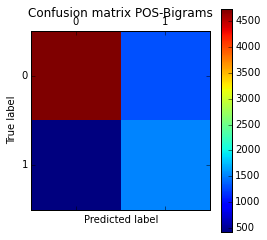

In [123]:
plt.clf()
plt.matshow(cm5)
plt.title('Confusion matrix POS-Bigrams')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Ultimatley the adjustments made in Part B3 (removing of stop words), outperformed the part of speech bigram (B4), but the results were incredibly similar. Both classifed approximately the same amount as "high" salary correctly (1546 for removing stop words, and 1526 for the part of speech bigram). The difference between the two (20) is incredibly small given the fact that the total data size was 8000 postings- so they performed relatively equally.